In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
import os
import nltk
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
import matplotlib.pyplot as plt
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/home/manuujrodcruz/.pyenv/versions/r2d2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="background:#ff6242;padding:20px;color:#ffffff;margin-top:10px;">
<b>El propósito de esta asignación es que el estudiante ponga en práctica la construcción de sistemas de recuperación de información basado en el modelo clásico de RI Vector Space Model, así como también que evalue la efectividad de estos modelos mediante el uso de una colección de referencia (Benchmark).
<br />
<br />
Para esta práctica estará utilizando el siguiente repositorio:https://github.com/oussbenk/cranfield-trec-dataset. En el mismo encontrarán los archivos  cran.all.1400.xml, cran.qry.xml, cranqrel.trec.txt:
<ul>
<li>cran.all.1400.xml contiene 1,400 resumenes de artículos científicos.</li>
<li>cran.qry.xml 225 términos que representan consultas.</li>
<li>cranqrel.trec.txt contiene los juicios de relevancia a dichas consultas.</li>
    </ul>  
<br />
<br />
Estudie en detalle la estructura y el contenido de este conjunto de documentos provistos antes de comenzar.    
<br />
<br />
En este trabajo, aparte del código, debe proveer una interpretación para cada tarea y un análisis para cada resultado obtenido que así lo amerite.</b>
</div>


## 1. Ejercicio 1
### Puntuación máxima de la tarea: 3 puntos
#### Limpieza y preparación de los datos, utilizando distintas técnicas de las ya vistas en clases. Para esta tarea utilizará el archivo cran.all.1400.xml, específicamente sus columnas title y text.


In [2]:
def wrap_trec_file(file_path):
    with open(file_path, 'r') as f:
        xml_content = f.read()
    return '<root>' + xml_content + '</root>'

In [3]:
import xml.etree.ElementTree as ElementTree
def load_documents():
    xml = wrap_trec_file('cranfield-trec-dataset/cran.all.1400.xml')
    root = ElementTree.fromstring(xml)
    df = pd.DataFrame(columns=['docno', 'title', 'author', 'bib', 'text'])
    for doc in root:
        docno = doc.find('docno').text.strip() if doc.find('docno').text is not None else ''
        title = doc.find('title').text.strip() if doc.find('title').text is not None else ''
        author = doc.find('author').text.strip() if doc.find('author').text is not None else ''
        bib = doc.find('bib').text.strip() if doc.find('bib').text is not None else ''
        text = doc.find('text').text.strip() if doc.find('text').text is not None else ''
        new_row = pd.DataFrame({'docno': [docno], 'title': [title], 'author': [author], 'bib': [bib], 'text': [text]})
        df = pd.concat([df, new_row], ignore_index=True)
    return df
docs = load_documents()

In [4]:
def load_queries(query_file):
    tree = ElementTree.parse(query_file)
    root = tree.getroot()
    queries = []
    query_ids = []
    for topic in root.findall('top'):
        qid = topic.find('num').text.strip()
        title = topic.find('title').text
        queries.append(title)
        query_ids.append(qid)
    return query_ids, queries
query_ids, queries = load_queries('cranfield-trec-dataset/cran.qry.xml')

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [6]:
def data_cleaning(dataframe):
    dataframe['title'] = dataframe['title'].str.lower()
    dataframe['text'] = dataframe['text'].str.lower()
    dataframe['title'] = dataframe['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    dataframe['text'] = dataframe['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    dataframe['title'] = dataframe['title'].apply(word_tokenize)
    dataframe['text'] = dataframe['text'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    dataframe['title'] = dataframe['title'].apply(lambda x: [word for word in x if word not in stop_words])
    dataframe['text'] = dataframe['text'].apply(lambda x: [word for word in x if word not in stop_words])
    dataframe['title'] = dataframe['title'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])
    dataframe['text'] = dataframe['text'].apply(lambda x: [token.lemma_ for token in nlp(' '.join(x))])
    return dataframe
docs = data_cleaning(docs)

## 2. Ejercicio 2
### Puntuación máxima de la tarea: 2 puntos
#### Construir al menos dos modelos de recuperación de información basado en el modelo vectorial, visto en detalle en clases, cada uno con una configuración distinta de textos, tal y como se indica a continuación: solo title y title+text.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

nlp = spacy.load("en_core_web_sm")

class VectorSpaceModel:
    def __init__(self, stop_words='english', max_df=0.85, min_df=2):
        self.vectorizer = TfidfVectorizer(
            stop_words=stop_words,
            max_df=max_df,
            min_df=min_df,
            ngram_range=(1, 2)
        )
        self.document_vectors = None
        self.is_trained = False
        
    def train(self, documents):
        self.document_vectors = self.vectorizer.fit_transform(documents)
        self.is_trained = True
        
    def vectorize_query(self, query_text):
        self._validate_trained_model()
        return self.vectorizer.transform([query_text])
        
    def rank_documents(self, query_vector, document_ids):
        similarities = cosine_similarity(query_vector, self.document_vectors).flatten()
        ranked_indices = np.argsort(similarities)[::-1]
        return [(document_ids.iloc[i], similarities[i]) for i in ranked_indices]
    
    def _validate_trained_model(self):
        if not self.is_trained:
            raise ValueError("Model must be trained before querying")

def normalize_text(text):
    return text.lower()

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(tokens, stopwords_set):
    return [token for token in tokens if token not in stopwords_set]

def lemmatize_tokens(tokens):
    return [token.lemma_ for token in nlp(' '.join(tokens))]

def preprocess_query(query, stopwords_set):
    normalized = normalize_text(query)
    clean_text = remove_punctuation(normalized)
    tokens = word_tokenize(clean_text)
    filtered_tokens = remove_stopwords(tokens, stopwords_set)
    lemmatized = lemmatize_tokens(filtered_tokens)
    return ' '.join(lemmatized)

def preprocess_all_queries(queries):
    stopwords_set = set(stopwords.words('english'))
    return [preprocess_query(query, stopwords_set) for query in queries]

def create_trec_result_line(query_id, doc_id, rank, score, run_name):
    return f"{query_id} Q0 {doc_id} {rank} {score:.6f} {run_name}\n"

def save_trec_results(query_id, ranked_documents, run_name, output_file, max_results=1000):
    with open(output_file, 'a') as file:
        for rank, (doc_id, score) in enumerate(ranked_documents[:max_results], 1):
            result_line = create_trec_result_line(query_id, doc_id, rank, score, run_name)
            file.write(result_line)

def prepare_title_only_documents(documents_df):
    return documents_df['title'].apply(
        lambda title: ' '.join(title) if isinstance(title, list) else title
    )

def prepare_title_text_documents(documents_df):
    return documents_df.apply(
        lambda row: ' '.join(row['title']) + ' ' + ' '.join(row['text']), 
        axis=1
    )

def clear_output_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

def process_queries_for_model(model, query_ids, queries, document_ids, run_name, output_file):
    clear_output_file(output_file)
    
    for query_id, query_text in zip(query_ids, queries):
        query_vector = model.vectorize_query(query_text)
        ranked_documents = model.rank_documents(query_vector, document_ids)
        save_trec_results(query_id, ranked_documents, run_name, output_file)

def build_title_only_model(documents_df, query_ids, processed_queries):
    title_documents = prepare_title_only_documents(documents_df)
    model = VectorSpaceModel()
    model.train(title_documents)
    
    output_file = "trec_results_title_only.txt"
    process_queries_for_model(
        model, query_ids, processed_queries, 
        documents_df['docno'], "vectorial_title", output_file
    )
    
    return model, len(title_documents)

def build_title_text_model(documents_df, query_ids, processed_queries):
    title_text_documents = prepare_title_text_documents(documents_df)
    model = VectorSpaceModel()
    model.train(title_text_documents)
    
    output_file = "trec_results_title_text.txt"
    process_queries_for_model(
        model, query_ids, processed_queries,
        documents_df['docno'], "vectorial_title_text", output_file
    )
    
    return model, len(title_text_documents)

def display_model_summary(model_name, document_count, query_count, output_file):
    print(f"\n{model_name}")
    print("-" * 40)
    print(f"✓ Resultados guardados en: {output_file}")
    print(f"  Documentos indexados: {document_count}")
    print(f"  Consultas procesadas: {query_count}")

def build_vector_space_models(documents_df, queries, query_ids):
    processed_queries = preprocess_all_queries(queries)
    
    print("Construyendo modelos vectoriales")
    print("=" * 60)
    
    title_model, title_doc_count = build_title_only_model(
        documents_df, query_ids, processed_queries
    )
    display_model_summary(
        "1. Modelo Vectorial - Solo Títulos", 
        title_doc_count, len(query_ids), "trec_results_title_only.txt"
    )
    
    title_text_model, title_text_doc_count = build_title_text_model(
        documents_df, query_ids, processed_queries
    )
    display_model_summary(
        "2. Modelo Vectorial - Títulos + Texto", 
        title_text_doc_count, len(query_ids), "trec_results_title_text.txt"
    )
    
    print("\n" + "=" * 60)
    print("MODELOS VECTORIALES CONSTRUIDOS EXITOSAMENTE")
    print("=" * 60)
    
    return {
        'title_only': title_model,
        'title_text': title_text_model
    }

trained_models = build_vector_space_models(docs, queries, query_ids)

Construyendo modelos. . .

1. Modelo Vectorial - Solo Títulos
----------------------------------------
✓ Modelo entrenado y resultados guardados en: trec_results_title_only.txt
  - Documentos indexados: 1400
  - Consultas procesadas: 225

2. Modelo Vectorial - Títulos + Texto
----------------------------------------
✓ Modelo entrenado y resultados guardados en: trec_results_title_only.txt
  - Documentos indexados: 1400
  - Consultas procesadas: 225

2. Modelo Vectorial - Títulos + Texto
----------------------------------------
✓ Modelo entrenado y resultados guardados en: trec_results_title_text.txt
  - Documentos indexados: 1400
  - Consultas procesadas: 225

MODELOS VECTORIALES CONSTRUIDOS EXITOSAMENTE
✓ Modelo entrenado y resultados guardados en: trec_results_title_text.txt
  - Documentos indexados: 1400
  - Consultas procesadas: 225

MODELOS VECTORIALES CONSTRUIDOS EXITOSAMENTE


## 3. Ejercicio 3
### Puntuación máxima de la tarea: 5 puntos
#### Evaluar los modelos de recuperación de información construidos, mediante la utilización de la colección de referencia dada (Archivos cran.qry.xml y cranqrel.trec.txt). Seleccione dos métricas ampliamente utilizadas en la evaluación de este tipo de sistemas y analice los resultados para determinar cual es el mejor de los modelos.

**Métricas seleccionadas:**
1. **Precisión@K (P@10):** Proporción de documentos relevantes en los primeros 10 resultados
2. **Recall@K (R@10):** Proporción de documentos relevantes totales que fueron recuperados en los primeros 10 resultados

**Análisis:** Se evaluarán ambos modelos vectoriales (Title-Only vs Title+Text) usando estas métricas para determinar cuál proporciona mejor efectividad de recuperación.

In [ ]:
class RetrievalEvaluator:
    def __init__(self, qrel_file):
        self.relevance_judgments = self._load_relevance_judgments(qrel_file)
        self.relevance_dict = self._build_relevance_dict()
        
    def _load_relevance_judgments(self, qrel_file):
        relevance_data = []
        with open(qrel_file, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 4:
                    query_id, doc_id, relevance = parts[0], parts[2], int(parts[3])
                    if relevance > 0:
                        relevance_data.append((query_id, doc_id))
        return relevance_data
    
    def _build_relevance_dict(self):
        relevance_dict = {}
        for query_id, doc_id in self.relevance_judgments:
            if query_id not in relevance_dict:
                relevance_dict[query_id] = set()
            relevance_dict[query_id].add(doc_id)
        return relevance_dict
    
    def _parse_trec_results(self, results_file):
        results = {}
        with open(results_file, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 6:
                    query_id, doc_id, rank, score = parts[0], parts[2], int(parts[3]), float(parts[4])
                    
                    if query_id not in results:
                        results[query_id] = []
                    results[query_id].append((doc_id, rank, score))
        
        for query_id in results:
            results[query_id].sort(key=lambda x: x[1])
        
        return results
    
    def calculate_precision_at_k(self, retrieved_docs, relevant_docs, k=10):
        if not retrieved_docs:
            return 0.0
        
        top_k_docs = [doc[0] for doc in retrieved_docs[:k]]
        relevant_in_top_k = len([doc for doc in top_k_docs if doc in relevant_docs])
        
        return relevant_in_top_k / min(k, len(top_k_docs))
    
    def calculate_recall_at_k(self, retrieved_docs, relevant_docs, k=10):
        if not relevant_docs:
            return 0.0
        
        top_k_docs = [doc[0] for doc in retrieved_docs[:k]]
        relevant_in_top_k = len([doc for doc in top_k_docs if doc in relevant_docs])
        
        return relevant_in_top_k / len(relevant_docs)
    
    def evaluate_single_query(self, query_id, retrieved_docs, relevant_docs, k=10):
        precision = self.calculate_precision_at_k(retrieved_docs, relevant_docs, k)
        recall = self.calculate_recall_at_k(retrieved_docs, relevant_docs, k)
        
        return {
            'query_id': query_id,
            'precision': precision,
            'recall': recall,
            'relevant_total': len(relevant_docs),
            'relevant_found': len([doc for doc in retrieved_docs[:k] if doc[0] in relevant_docs])
        }
    
    def evaluate_model(self, results_file, model_name, k=10):
        results = self._parse_trec_results(results_file)
        
        precision_scores = []
        recall_scores = []
        query_evaluations = []
        
        for query_id in sorted(self.relevance_dict.keys()):
            if query_id in results:
                retrieved_docs = results[query_id]
                relevant_docs = self.relevance_dict[query_id]
                
                evaluation = self.evaluate_single_query(query_id, retrieved_docs, relevant_docs, k)
                
                precision_scores.append(evaluation['precision'])
                recall_scores.append(evaluation['recall'])
                query_evaluations.append(evaluation)
        
        avg_precision = np.mean(precision_scores) if precision_scores else 0.0
        avg_recall = np.mean(recall_scores) if recall_scores else 0.0
        
        return {
            'model_name': model_name,
            'avg_precision_at_k': avg_precision,
            'avg_recall_at_k': avg_recall,
            'precision_scores': precision_scores,
            'recall_scores': recall_scores,
            'query_evaluations': query_evaluations,
            'total_queries': len(query_evaluations)
        }
    
    def get_best_and_worst_queries(self, evaluation_results):
        precisions = evaluation_results['precision_scores']
        best_idx = np.argmax(precisions)
        worst_idx = np.argmin(precisions)
        
        return (
            evaluation_results['query_evaluations'][best_idx],
            evaluation_results['query_evaluations'][worst_idx]
        )
    
    def print_evaluation_summary(self, evaluation_results):
        print(f"\n{'='*60}")
        print(f"EVALUACIÓN: {evaluation_results['model_name']}")
        print(f"{'='*60}")
        
        print(f"Precisión@10 promedio: {evaluation_results['avg_precision_at_k']:.4f}")
        print(f"Recall@10 promedio: {evaluation_results['avg_recall_at_k']:.4f}")
        print(f"Consultas evaluadas: {evaluation_results['total_queries']}")
        
        precisions = evaluation_results['precision_scores']
        recalls = evaluation_results['recall_scores']
        
        print(f"\nEstadísticas detalladas:")
        print(f"  Precisión - Min: {min(precisions):.4f}, Max: {max(precisions):.4f}")
        print(f"  Recall - Min: {min(recalls):.4f}, Max: {max(recalls):.4f}")
        
        best_query, worst_query = self.get_best_and_worst_queries(evaluation_results)
        
        print(f"\nMejor consulta (Precisión): {best_query['query_id']} "
              f"(P@10: {best_query['precision']:.4f})")
        print(f"Peor consulta (Precisión): {worst_query['query_id']} "
              f"(P@10: {worst_query['precision']:.4f})")

def determine_better_model(eval1, eval2):
    prec_diff = eval1['avg_precision_at_k'] - eval2['avg_precision_at_k']
    recall_diff = eval1['avg_recall_at_k'] - eval2['avg_recall_at_k']
    
    if prec_diff > 0 and recall_diff > 0:
        return eval1['model_name'], "superior en ambas métricas"
    elif prec_diff < 0 and recall_diff < 0:
        return eval2['model_name'], "superior en ambas métricas"
    else:
        better_precision = eval1['model_name'] if prec_diff > 0 else eval2['model_name']
        better_recall = eval2['model_name'] if prec_diff > 0 else eval1['model_name']
        return None, f"{better_precision} mejor en precisión, {better_recall} mejor en recall"

def print_comparison_header():
    print(f"\n{'='*80}")
    print("COMPARACIÓN DE MODELOS")
    print(f"{'='*80}")
    print(f"{'Métrica':<20} {'Modelo 1':<20} {'Modelo 2':<20} {'Diferencia':<15}")
    print("-" * 80)

def print_metric_comparison(metric_name, value1, value2):
    difference = value1 - value2
    print(f"{metric_name:<20} {value1:<20.4f} {value2:<20.4f} {difference:<15.4f}")

def compare_models(evaluation1, evaluation2):
    print_comparison_header()
    
    print_metric_comparison("Precisión@10", 
                           evaluation1['avg_precision_at_k'], 
                           evaluation2['avg_precision_at_k'])
    
    print_metric_comparison("Recall@10", 
                           evaluation1['avg_recall_at_k'], 
                           evaluation2['avg_recall_at_k'])
    
    better_model, conclusion = determine_better_model(evaluation1, evaluation2)
    
    print(f"\n{'CONCLUSIÓN:':<20}")
    if better_model:
        print(f"El modelo {better_model} es {conclusion}")
    else:
        print("Los modelos tienen fortalezas complementarias:")
        print(f"  - {conclusion}")

evaluator = RetrievalEvaluator("cranfield-trec-dataset/cranqrel.trec.txt")

print("Evaluando modelos vectoriales...")
evaluation_title = evaluator.evaluate_model("trec_results_title_only.txt", "Vectorial Title-Only")
evaluation_title_text = evaluator.evaluate_model("trec_results_title_text.txt", "Vectorial Title+Text")

evaluator.print_evaluation_summary(evaluation_title)
evaluator.print_evaluation_summary(evaluation_title_text)

compare_models(evaluation_title, evaluation_title_text)

Evaluando modelos vectoriales...

EVALUACIÓN: Vectorial Title-Only
Precisión@10 promedio: 0.0079
Recall@10 promedio: 0.0075
Consultas evaluadas: 152

Estadísticas detalladas:
  Precisión - Min: 0.0000, Max: 0.3000
  Recall - Min: 0.0000, Max: 0.3333

Mejor consulta (Precisión): 1 (P@10: 0.3000)
Peor consulta (Precisión): 10 (P@10: 0.0000)

EVALUACIÓN: Vectorial Title+Text
Precisión@10 promedio: 0.0112
Recall@10 promedio: 0.0093
Consultas evaluadas: 152

Estadísticas detalladas:
  Precisión - Min: 0.0000, Max: 0.4000
  Recall - Min: 0.0000, Max: 0.3333

Mejor consulta (Precisión): 1 (P@10: 0.4000)
Peor consulta (Precisión): 10 (P@10: 0.0000)

COMPARACIÓN DE MODELOS
Métrica              Modelo 1             Modelo 2             Diferencia     
--------------------------------------------------------------------------------
Precisión@10         0.0079               0.0112               -0.0033        
Recall@10            0.0075               0.0093               -0.0018        

CONCLUSI

Creando visualizaciones comparativas...


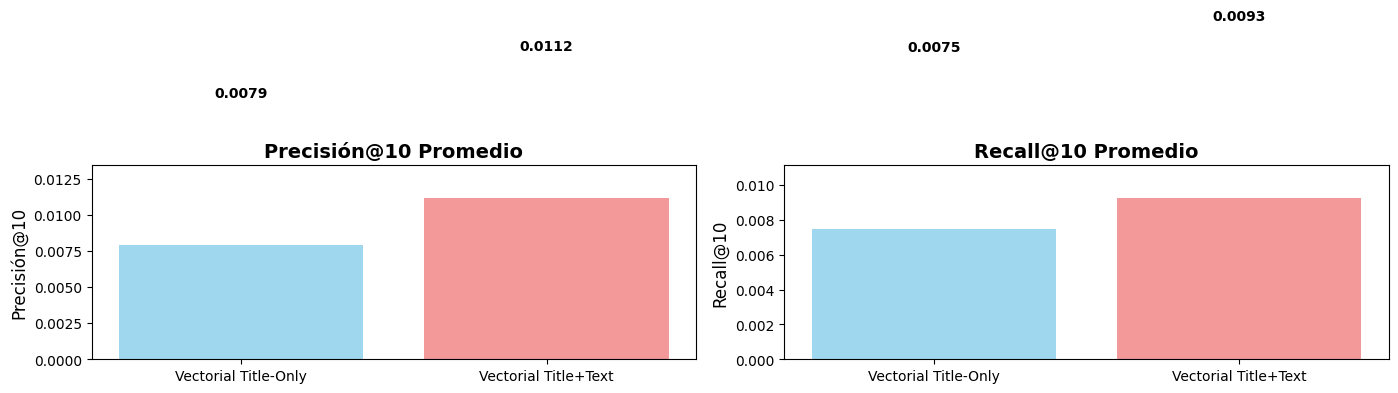

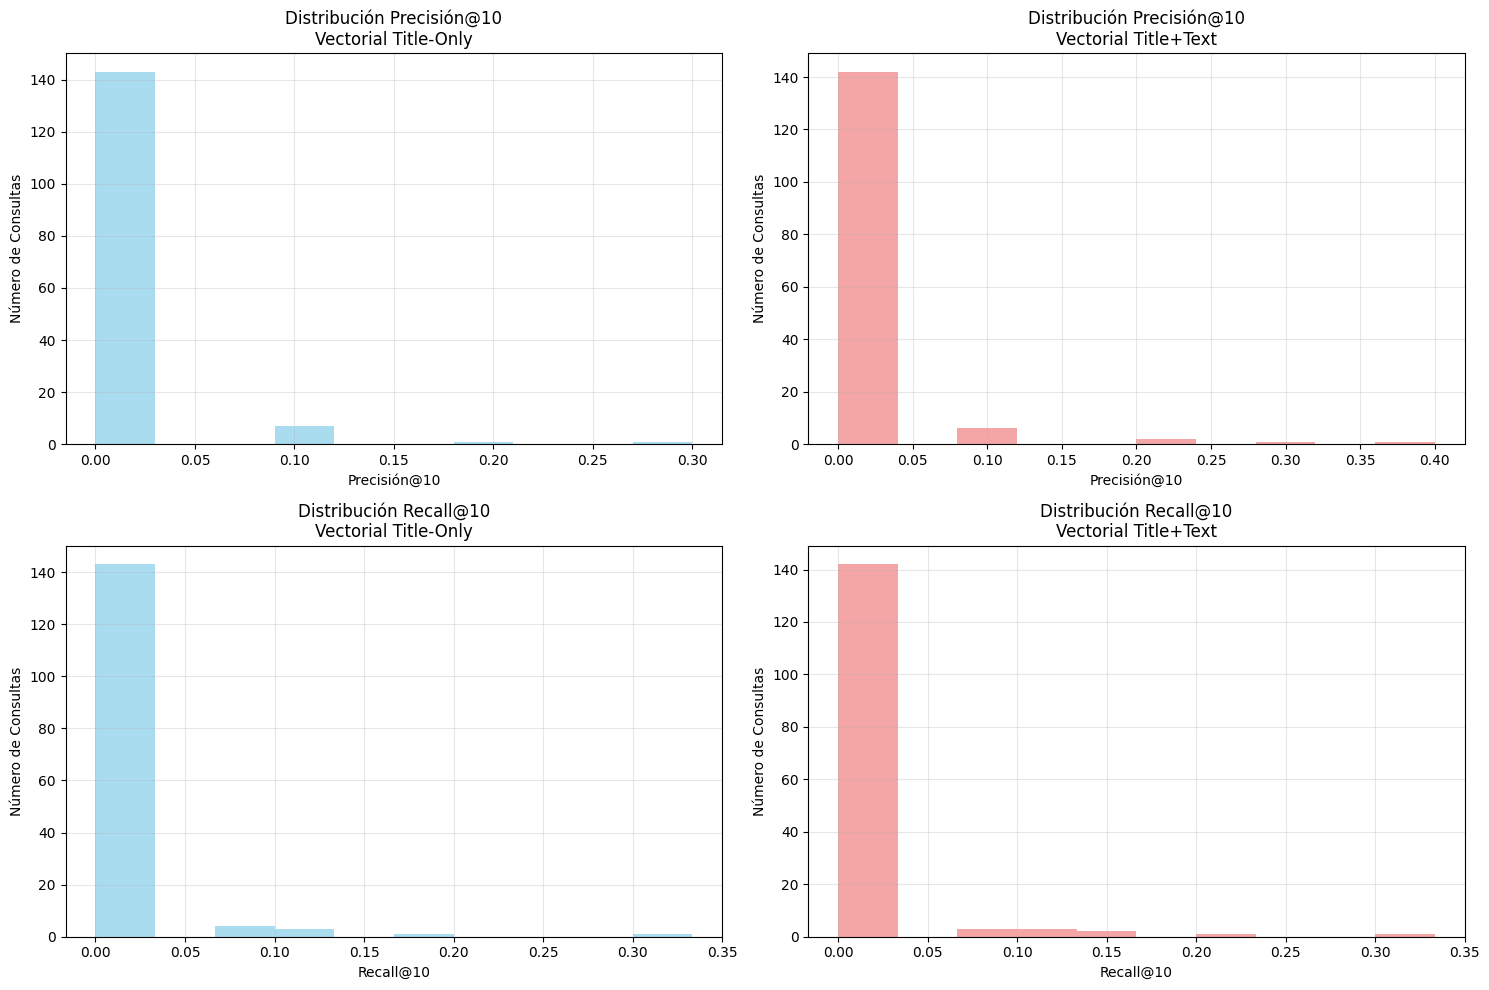

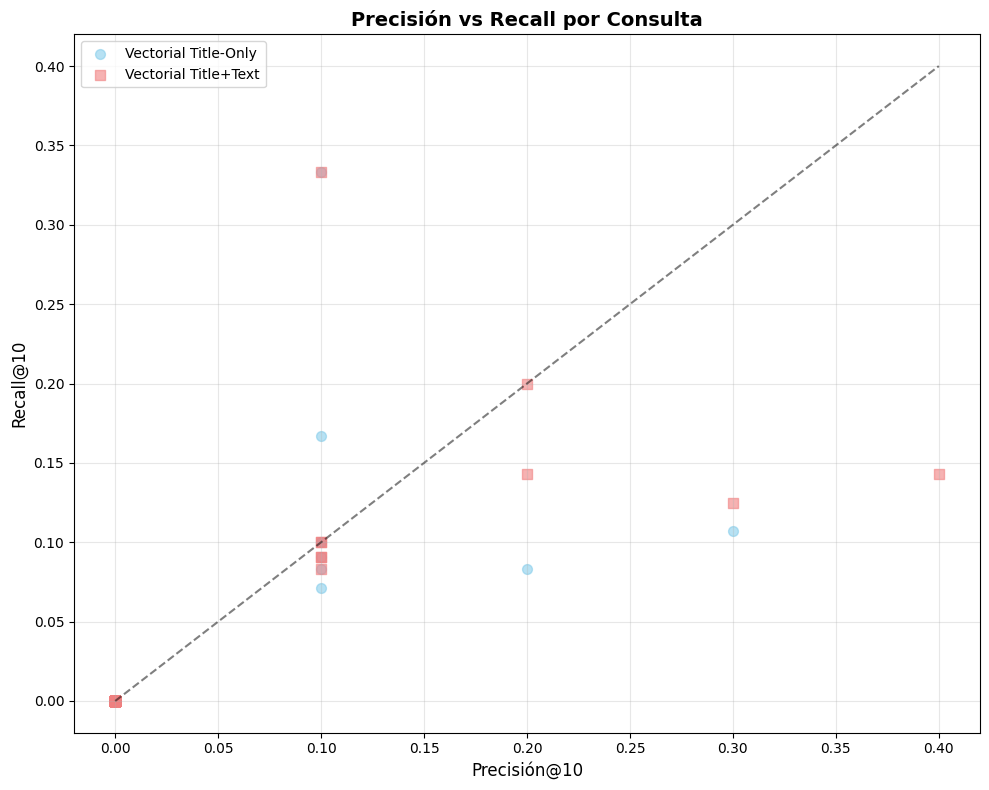

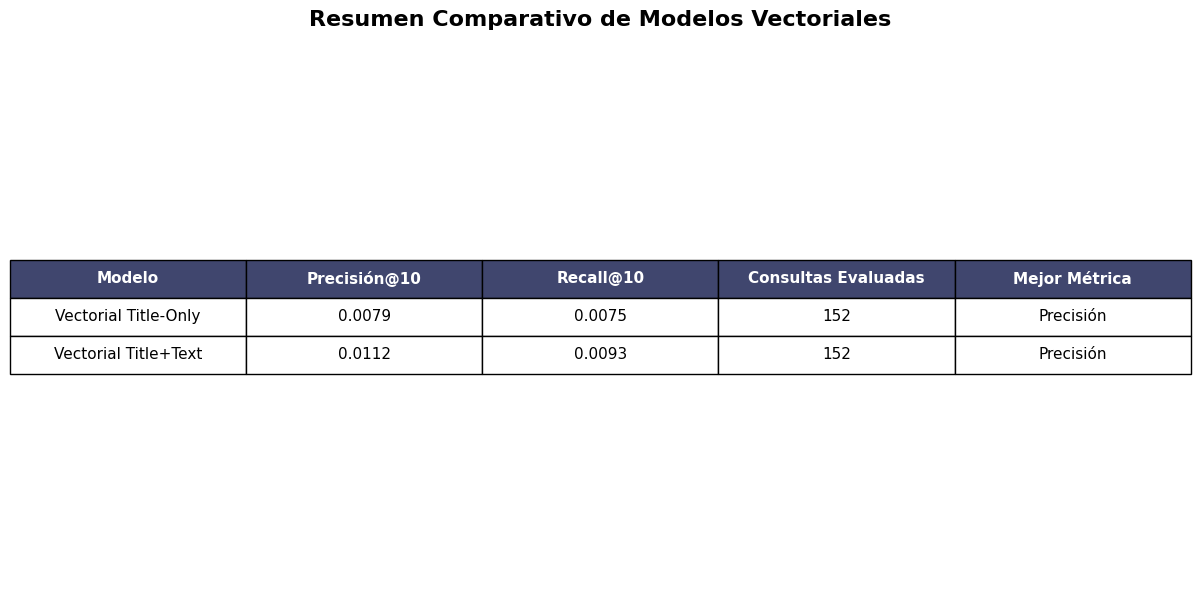

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class ModelVisualizer:
    def __init__(self, evaluation_results):
        self.evaluations = evaluation_results
        
    def extract_model_data(self):
        model_names = [eval_result['model_name'] for eval_result in self.evaluations]
        precisions = [eval_result['avg_precision_at_k'] for eval_result in self.evaluations]
        recalls = [eval_result['avg_recall_at_k'] for eval_result in self.evaluations]
        return model_names, precisions, recalls
    
    def create_metric_bar_chart(self, ax, values, title, ylabel, colors):
        model_names, _, _ = self.extract_model_data()
        bars = ax.bar(model_names, values, color=colors, alpha=0.8)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_ylim(0, max(values) * 1.2)
        
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        
        return bars
    
    def create_metrics_comparison(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        model_names, precisions, recalls = self.extract_model_data()
        colors = ['skyblue', 'lightcoral']
        
        self.create_metric_bar_chart(ax1, precisions, 'Precisión@10 Promedio', 'Precisión@10', colors)
        self.create_metric_bar_chart(ax2, recalls, 'Recall@10 Promedio', 'Recall@10', colors)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def create_histogram(self, ax, values, title, xlabel, color):
        ax.hist(values, bins=10, alpha=0.7, color=color)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Número de Consultas')
        ax.grid(True, alpha=0.3)
    
    def create_query_performance_distribution(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        colors = ['skyblue', 'lightcoral']
        
        for i, eval_result in enumerate(self.evaluations):
            model_name = eval_result['model_name']
            precisions = eval_result['precision_scores']
            recalls = eval_result['recall_scores']
            
            self.create_histogram(axes[0, i], precisions, 
                                f'Distribución Precisión@10\n{model_name}', 
                                'Precisión@10', colors[i])
            
            self.create_histogram(axes[1, i], recalls, 
                                f'Distribución Recall@10\n{model_name}', 
                                'Recall@10', colors[i])
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def add_ideal_performance_line(self, ax, max_value):
        ax.plot([0, max_value], [0, max_value], 'k--', alpha=0.5, label='Rendimiento Ideal')
    
    def create_scatter_precision_recall(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = ['skyblue', 'lightcoral']
        markers = ['o', 's']
        
        max_value = 0
        for i, eval_result in enumerate(self.evaluations):
            precisions = eval_result['precision_scores']
            recalls = eval_result['recall_scores']
            
            ax.scatter(precisions, recalls, 
                      color=colors[i], 
                      marker=markers[i],
                      alpha=0.6, 
                      s=50,
                      label=eval_result['model_name'])
            
            max_value = max(max_value, max(precisions + recalls))
        
        ax.set_xlabel('Precisión@10', fontsize=12)
        ax.set_ylabel('Recall@10', fontsize=12)
        ax.set_title('Precisión vs Recall por Consulta', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        self.add_ideal_performance_line(ax, max_value)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def prepare_summary_table_data(self):
        table_data = []
        headers = ['Modelo', 'Precisión@10', 'Recall@10', 'Consultas Evaluadas', 'Mejor Métrica']
        
        for eval_result in self.evaluations:
            mejor_metrica = "Precisión" if eval_result['avg_precision_at_k'] > eval_result['avg_recall_at_k'] else "Recall"
            
            row = [
                eval_result['model_name'],
                f"{eval_result['avg_precision_at_k']:.4f}",
                f"{eval_result['avg_recall_at_k']:.4f}",
                str(eval_result['total_queries']),
                mejor_metrica
            ]
            table_data.append(row)
        
        return headers, table_data
    
    def style_summary_table(self, table, headers):
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 2)
        
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
    
    def create_summary_table(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis('tight')
        ax.axis('off')
        
        headers, table_data = self.prepare_summary_table_data()
        
        table = ax.table(cellText=table_data, colLabels=headers, 
                        cellLoc='center', loc='center', 
                        cellColours=None)
        
        self.style_summary_table(table, headers)
        
        ax.set_title('Resumen Comparativo de Modelos Vectoriales', 
                    fontsize=16, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        return fig

visualizer = ModelVisualizer([evaluation_title, evaluation_title_text])

print("Creando visualizaciones comparativas...")
metrics_fig = visualizer.create_metrics_comparison()
distribution_fig = visualizer.create_query_performance_distribution()
scatter_fig = visualizer.create_scatter_precision_recall()
summary_fig = visualizer.create_summary_table()